# Court Opinions Knowledge Graph (GLiNER)

This notebook builds a knowledge graph from **Court Opinions** (e.g., SCOTUS) using **GLiNER**.
It is part of the Universal Legal Knowledge Graph prototype.

In [ ]:
!pip install gliner networkx matplotlib tqdm -q

In [3]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from gliner import GLiNER
from tqdm import tqdm
import os

## 1. Load Data
Loading `opinions.json` or `opinion_chunks.json`.

In [4]:
# Load opinions data
files = ['opinions.json', 'opinion_chunks.json', 'opinions_full.json']
target_file = None

for f in files:
    if os.path.exists(f):
        target_file = f
        break

if not target_file:
    print("Warning: No data file found. Using dummy data.")
    data = [
        {"text": "Justice Roberts delivered the opinion of the Court. In the case of Roe v. Wade, 410 U.S. 113 (1973), the Court held..."},
        {"text": "Petitioner John Doe argues that the Agency violated the Administrative Procedure Act."}
    ]
else:
    print(f"Loading data from {target_file}...")
    with open(target_file, 'r') as f:
        raw_data = json.load(f)
    
    data = []
    if isinstance(raw_data, list):
        # Limit for prototype speed
        limit = 50
        for item in raw_data[:limit]: 
            text = ""
            # Try various common keys
            if isinstance(item, str):
                text = item
            elif isinstance(item, dict):
                if 'text' in item: text = item['text']
                elif 'content' in item: text = item['content']
                elif 'body' in item: text = item['body']
                elif 'summary' in item: text = item['summary']
                elif 'chunk_text' in item:
                     if isinstance(item['chunk_text'], dict):
                         text = item['chunk_text'].get('text', '')
                     else:
                         text = str(item['chunk_text'])
            
            if text:
                data.append({'text': text})
    else:
        print("Unknown JSON structure")
        data = []
        
    print(f"Loaded {len(data)} items.")

Loading data from opinions.json...
Loaded 50 items.


## 2. Initialize GLiNER
Using the Labels specific to Case Law.

In [5]:
model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")

labels = [
    # People & Roles
    "Judge", "Justice", "Petitioner", "Respondent", "Plaintiff", "Defendant", "Attorney",
    
    # Institutions
    "Court", "Government Agency", "Organization", "Committee",
    
    # Legal Docs & Concepts
    "Case Citation", "Statute", "Constitution", "Amendment", "Precedent", "Doctrine",
    
    # Context
    "Date", "Location", "Topic"
]

/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## 3. Build the Graph

In [6]:
G = nx.Graph()

for i, item in enumerate(tqdm(data)):
    text = item.get('text', '')
    if not text or len(text) < 50: continue
    
    # Create Chunk Node
    chunk_id = f"opinion_chunk_{i}"
    G.add_node(chunk_id, type="Chunk", text=text[:50]+"...")
    
    # Extract Entities
    try:
        entities = model.predict_entities(text, labels)
    except Exception as e:
        print(f"Error processing chunk {i}: {e}")
        continue
    
    entity_names = []
    for entity in entities:
        label = entity['label']
        name = entity['text'].strip()
        
        # Add Entity Node
        G.add_node(name, type=label)
        
        # Edge: Chunk -> Entity
        G.add_edge(chunk_id, name, relation="MENTIONS")
        
        entity_names.append(name)
    
    # Edge: Entity <-> Entity (Co-occurrence)
    import itertools
    for e1, e2 in itertools.combinations(entity_names, 2):
        if not G.has_edge(e1, e2):
            G.add_edge(e1, e2, relation="CO_OCCURS", weight=1)
        else:
            G[e1][e2]['weight'] += 1

print(f"Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

100%|██████████| 50/50 [00:20<00:00,  2.49it/s]

Graph constructed: 258 nodes, 1572 edges.


## 4. Visualize

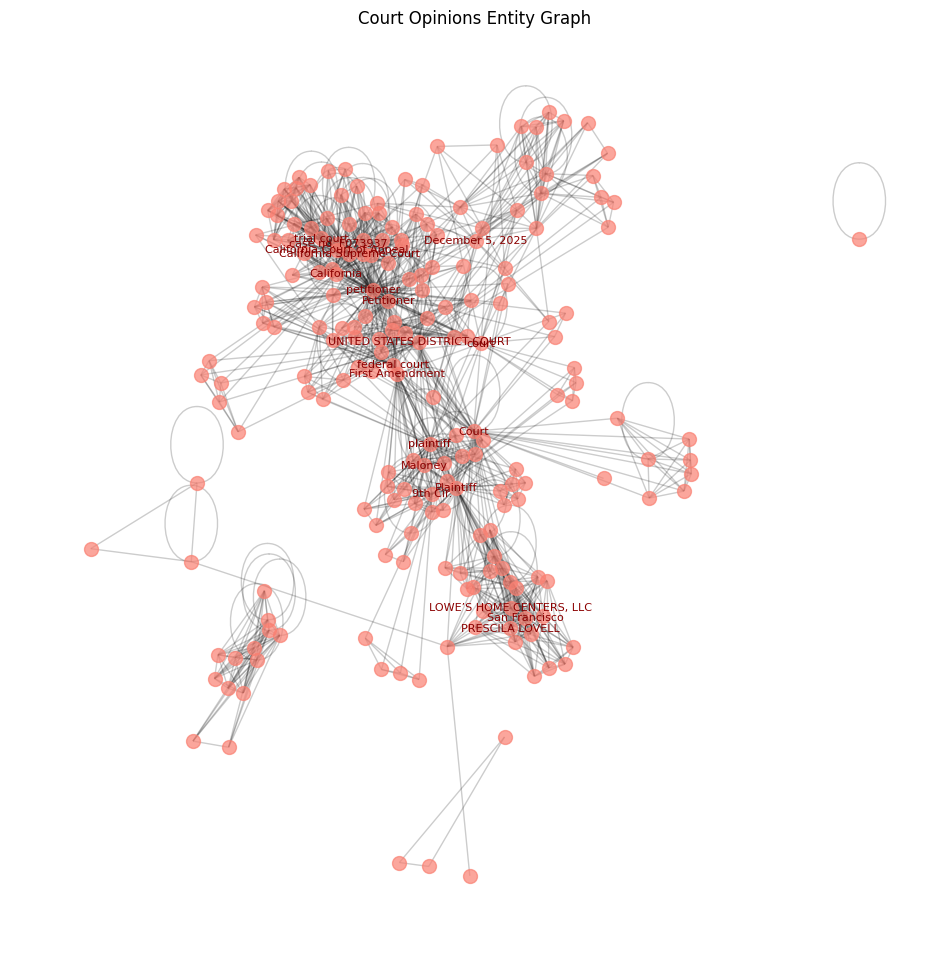

In [7]:
plt.figure(figsize=(12, 12))

# Filter out Chunk nodes for cleaner visualization
entity_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] != 'Chunk']
subgraph = G.subgraph(entity_nodes)

if len(subgraph.nodes()) > 0:
    pos = nx.spring_layout(subgraph, k=0.15, iterations=20)
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color="salmon", alpha=0.7)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
    
    final_labels = {}
    degrees = dict(subgraph.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:20]
    for node in top_nodes:
        final_labels[node] = node
        
    nx.draw_networkx_labels(subgraph, pos, labels=final_labels, font_size=8, font_color="darkred")
    
    plt.title("Court Opinions Entity Graph")
    plt.axis('off')
    plt.show()
else:
    print("Not enough entity nodes to visualize.")

In [8]:
nx.write_gexf(G, "opinions_knowledge_graph.gexf")
print("Graph saved to opinions_knowledge_graph.gexf")

Graph saved to opinions_knowledge_graph.gexf
